In [ ]:
import sys
# sys.path.append('G:/My Drive/Research/adaptation_abm/code')
sys.path.append('/home/twilliams/adaptation_abm/code')
import model.model as mod_code
import experiments.POM as POM
import plot.single_run as plt_single
import imp
import numpy as np
import pickle
imp.reload(mod_code)
import matplotlib.pyplot as plt
import model.base_inputs as base_inputs
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

In [ ]:
f = '../../outputs/2019_10_15_4/POM/100000_10reps/input_params_0.pkl'
f = '../../outputs/2020_1_27_savings/POM/100000_10reps/input_params_0.pkl'
inputs = pickle.load(open(f, 'rb'))
inputs['adaptation']['burnin_period'] = 10

In [ ]:
inputs['model']['seed'] = 0
inputs['model']['T'] = 100
# inputs['agents']['wealth_init_mean'] *=1
# inputs['land']['random_effect_sd'] = 0.5
inputs['model']['n_agents'] = 60
inputs['agents']['land_area_multiplier'] = 1


# inputs['land']['wealth_N_conversion'] *= 0.9
# inputs['land']['organic_N_min_init'] = 6000
# inputs['land']['organic_N_max_init'] = 6000
# inputs['agents']['cash_req_mean'] *= 1.3
# inputs['land']['random_effect_sd'] = 0.1

# inputs['model']['adaptation_option'] = 'cover_crop'
# inputs['agents']['adap_type'] = 'always'
inputs['rangeland']['R0_frac'] = 0.3

In [ ]:
# m = mod_code.Model(inputs)
# for t in range(m.T):
#     m.step()

In [ ]:
# imp.reload(plt_single)
# plt_single.main(m, save=False)

In [ ]:
# # assess variability in yields
# print(m.land.yields.shape)
# ags = m.agents.land_area == 1.5
# o1 = np.mean(np.var(m.land.yields[:,ags], axis=0))
# o2 = np.mean(np.var(m.land.yields[:,ags], axis=1))
# print('agent variance is this fraction of annual variance')
# print(o2/o1)

# Baseline model testing

In [1]:
import sys
# sys.path.append('G:/My Drive/Research/adaptation_abm/code')
sys.path.append('/home/twilliams/adaptation_abm/code')
import model.model as mod_code
import plot.single_run as plt_single
import imp
import numpy as np
import pickle
imp.reload(mod_code)
import matplotlib.pyplot as plt
import model.base_inputs as base_inputs
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

In [41]:
# POM
f = '../../outputs/2020_1_31_3/POM/10000_10reps/input_params_0.pkl'
inputs = pickle.load(open(f, 'rb'))

In [ ]:
imp.reload(mod_code)
imp.reload(base_inputs)
inputs = base_inputs.compile()

inputs['model']['T'] = 200
inputs['model']['n_agents'] = 60
# inputs['rangeland']['range_farm_ratio'] = 0.5
# inputs['rangeland']['gr2'] = 0.1
# inputs['agents']['savings_acct'] = True
# inputs['rangeland']['rangeland_dynamics'] = True
# inputs['land']['fallow_N_add'] *= 5
# inputs['agents']['n_yr_smooth'] = 3
# inputs['climate']['rain_mu'] = 0.5
# inputs['agents']['savings_acct'] = False

# inputs['agents']['savings_init_mean'] = 0
# inputs['agents']['livestock_init'] = 5

In [42]:
m = mod_code.Model(inputs)
for t in range(m.T):
    m.step()

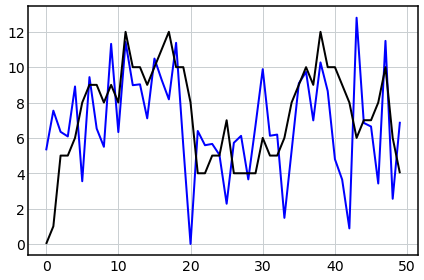

In [43]:
fig, ax = plt.subplots()
ax.plot(m.agents.crop_production[:,-1]/1000)
ax.plot(m.agents.ls_start[:,-1], color='k')

Text(0.5, 0, 'Year')

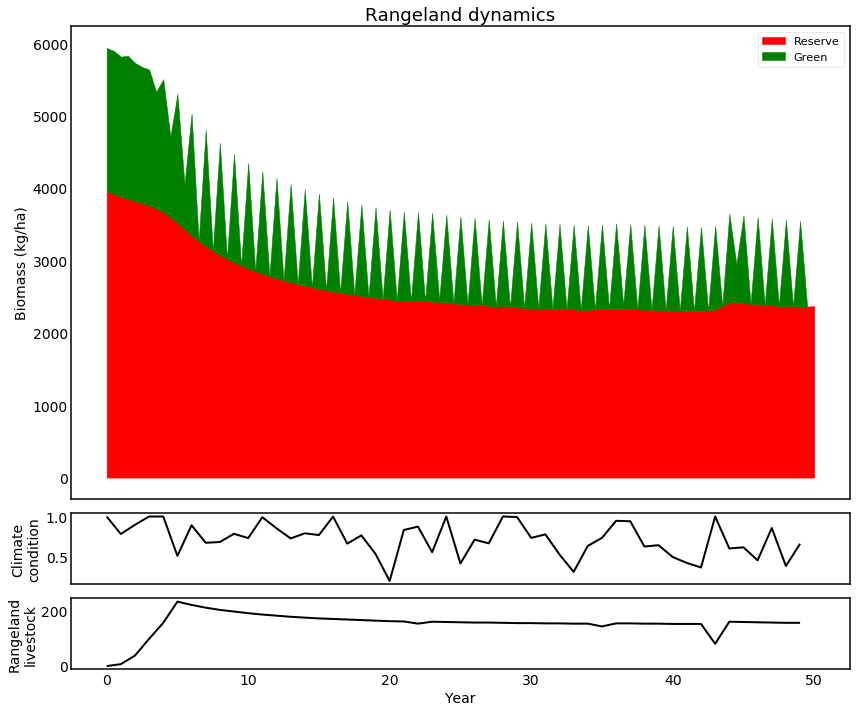

In [44]:
## plot the rangeland states
fig, axs = plt.subplots(3,1,figsize=(12,10),sharex=True, gridspec_kw={'height_ratios':[1,0.15,0.15]})
ax = axs[0]
# reserve biomass
ax.fill_between(np.arange(m.T+1), 0, m.rangeland.R, color='red', label='Reserve')
# format the green biomass
G = np.full([2*m.T], np.nan)
G[np.arange(m.T)*2] = m.rangeland.G_no_cons
G[np.arange(m.T)*2+1] = m.rangeland.G[:-1]
mids = (m.rangeland.R[:-1] + m.rangeland.R[1:]) / 2
R_all = np.full(2*m.T, np.nan)
R_all[np.arange(m.T)*2] = m.rangeland.R[:-1]
R_all[np.arange(m.T)*2+1] = mids

R_base = np.repeat(m.rangeland.R[:-1],2)
ax.fill_between(np.arange(2*m.T)/2, R_all, R_all+G, color='green', label='Green')

ax.grid(False)
ax.set_ylabel('Biomass (kg/ha)')
ax.legend()
ax.set_title('Rangeland dynamics')

# add rainfall and livestock total
axs[1].plot(m.climate.rain, color='k')
axs[1].grid(False)
axs[1].set_ylabel('Climate\ncondition')

axs[2].plot(m.rangeland.livestock_supported, color='k')
axs[2].grid(False)
axs[2].set_ylabel('Rangeland\nlivestock')
axs[2].set_xlabel('Year')

Text(0.5, 1.0, 'Livestock by agent type')

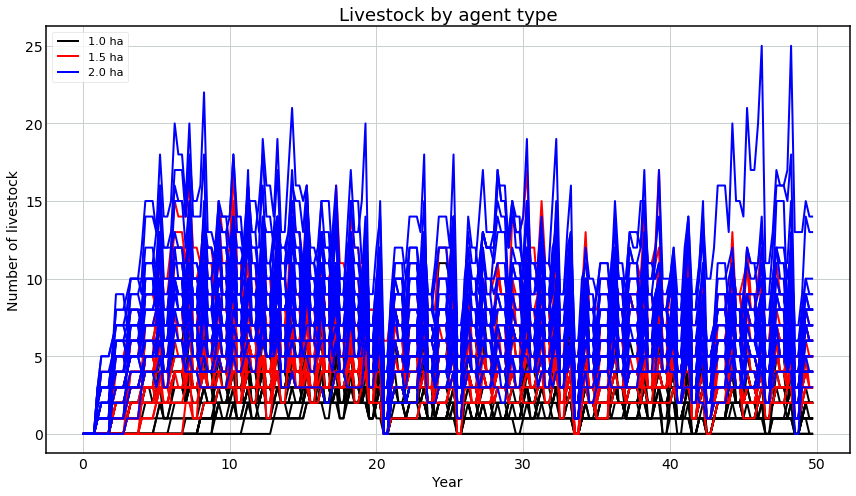

In [45]:
## livestock
fig, ax = plt.subplots(figsize=(12,7))
# format data
ls = np.full([4*m.T, m.n_agents], np.nan)
ls[4*np.arange(m.T)] = m.agents.ls_start
ls[4*np.arange(m.T)+1] = m.agents.ls_reprod
ls[4*np.arange(m.T)+2] = m.agents.ls_destock
ls[4*np.arange(m.T)+3] = m.agents.ls_stress

t = np.arange(ls.shape[0])/4
colors = {1:'k',1.5:'r',2:'b'}
labls = []

for a in range(m.n_agents):
    land = m.agents.land_area[a]
    lgd = '_nolegend_' if land in labls else '{} ha'.format(land)
    labls.append(land)  
    ax.plot(t,ls[:,a], color=colors[land], label=lgd)
    
ax.legend()
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.set_xlabel('Year')
ax.set_ylabel('Number of livestock')
ax.set_title('Livestock by agent type')

Text(0.5, 1.0, 'Wealth by agent type')

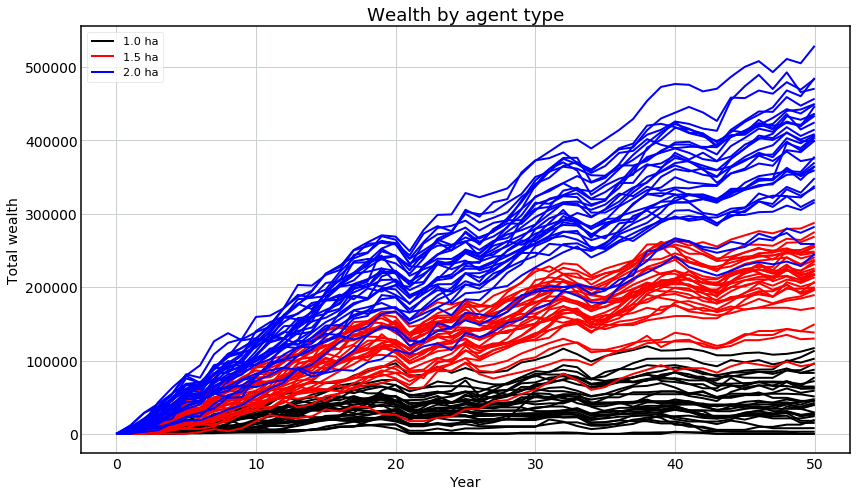

In [46]:
fig, ax = plt.subplots(figsize=(12,7))
colors = {1:'k',1.5:'r',2:'b'}
labls = []

for a in range(m.n_agents):
    land = m.agents.land_area[a]
    lgd = '_nolegend_' if land in labls else '{} ha'.format(land)
    labls.append(land)  
    ax.plot(m.agents.wealth[:,a], color=colors[land], label=lgd)
    
ax.legend()
# ax.xaxis.set_major_locator(MultipleLocator(1))
ax.set_xlabel('Year')
ax.set_ylabel('Total wealth')
ax.set_title('Wealth by agent type')

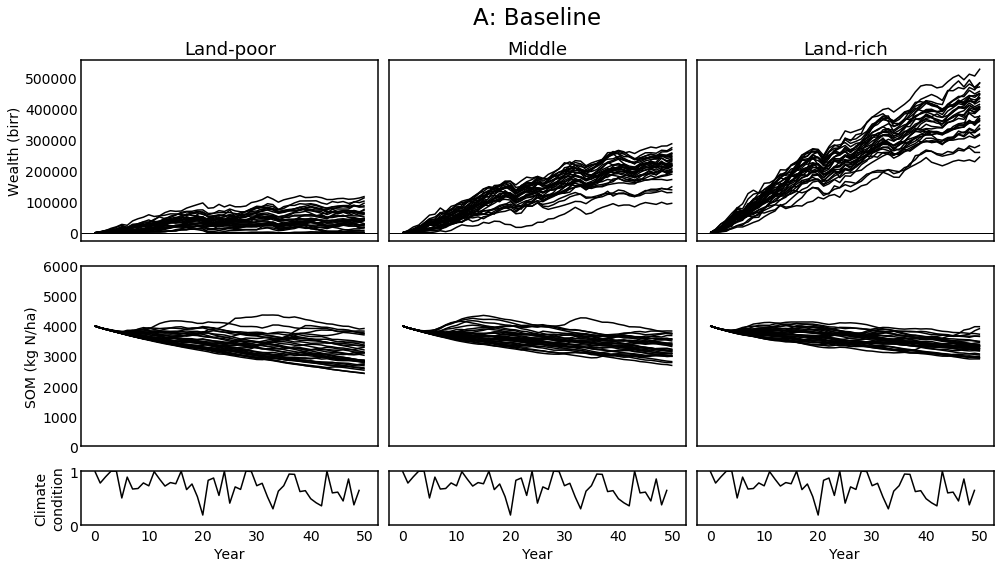

In [47]:
plt_single.separate(m)

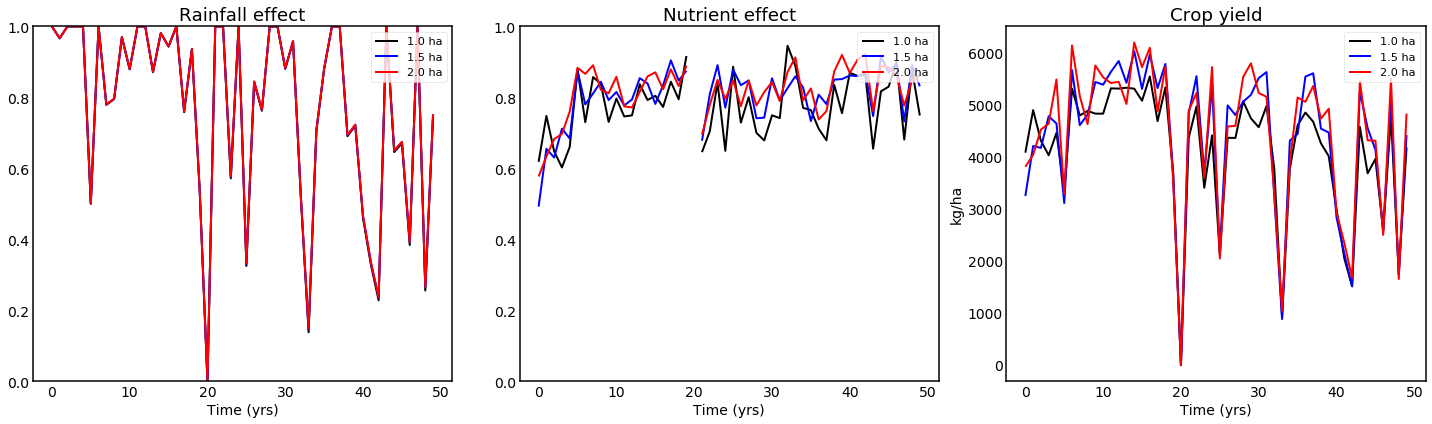

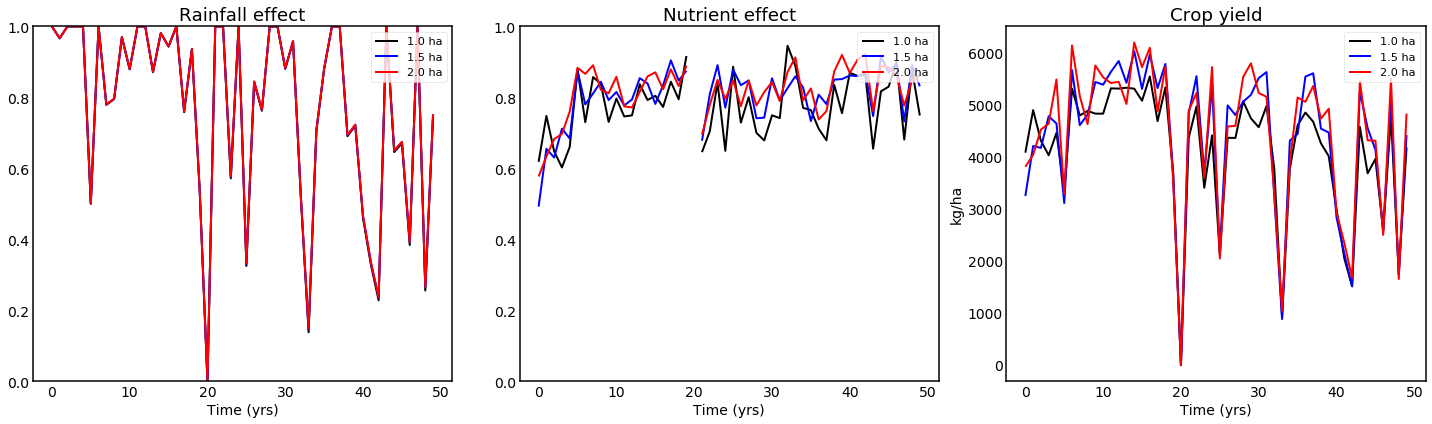

In [48]:
plt_single.type_yields(m, False)

In [49]:
for r in range(10):
    inputs['model']['seed'] = r
    m = mod_code.Model(inputs)
    for t in range(m.T):
        m.step()
    
    mod = m    
    n_yrs = 10
    prob = np.mean(mod.rangeland.destocking_rqd)
    threeA = True if ((prob >= 0.1) and (prob <= 0.5)) else False
    ## B: min(reserve biomass) > 0.2*R_max
    threeB = True if min(mod.rangeland.R >= 0.2 * mod.rangeland.R_max) else False
    ## C: there are livestock on the rangeland in the last n_yrs
    threeC = True if (min(mod.rangeland.livestock_supported[-n_yrs:]) > 0) else False
    print(prob) 
#     print(POM.fitting_metrics(m))

0.84
0.86
0.84
0.82
0.82
0.86
0.84
0.78
0.86
0.84


In [50]:
m.rangeland.livestock_supported / m.agents.N

array([0.        , 0.05050505, 1.07070707, 1.12121212, 2.25252525,
       2.3030303 , 2.19191919, 2.1010101 , 2.03030303, 1.96969697,
       1.7979798 , 1.88888889, 1.84848485, 1.80808081, 1.77777778,
       1.74747475, 1.72727273, 1.70707071, 1.68686869, 1.66666667,
       1.65656566, 1.63636364, 1.62626263, 1.61616162, 1.60606061,
       1.5959596 , 1.58585859, 1.58585859, 1.57575758, 1.56565657,
       1.56565657, 1.44444444, 1.57575758, 1.57575758, 1.56565657,
       1.46464646, 1.57575758, 1.56565657, 1.56565657, 1.55555556,
       1.55555556, 1.55555556, 1.54545455, 1.54545455, 1.54545455,
       1.53535354, 1.53535354, 1.53535354, 1.53535354, 1.53535354])